In [21]:
import torch
import pytorch3d
import torch_geometric
import warnings
warnings.filterwarnings('ignore')

print("PyTorch:", torch.__version__)
print("MPS:", torch.backends.mps.is_available())
print("PyTorch3D:", pytorch3d.__version__)
print("Torch Geometric", torch_geometric.__version__)

PyTorch: 2.7.1
MPS: True
PyTorch3D: 0.7.8
Torch Geometric 2.6.1


In [22]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from datetime import datetime
import torch.nn as nn
from torch.optim import Adam
from pytorch3d.utils import ico_sphere
from tqdm import tqdm
import os

from hiegan.config import Config
from hiegan.utils.render_utils import visualize_complete_sample, quick_batch_overview
from hiegan.dataset import ShapeNetMVDataset
from hiegan.utils.collate import MeshCollator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [24]:
# --- Configuration ---
cfg = Config()
device = cfg.DEVICE
print(f"Using device: {device}")

Using device: cpu


In [25]:
# --- Dataset ---
ds = ShapeNetMVDataset(cfg.DATASET_ROOT, image_size=cfg.IMAGE_SIZE, multi_view=cfg.MULTI_VIEW)
print(f"Dataset size: {len(ds)}")

# Test loading a sample
if len(ds) > 0:
    sample_img, sample_mesh, sample_metadata = ds[0]
    print(f"Sample image shape: {sample_img.shape}")
    print(f"Sample meta {sample_metadata}")


Dataset loaded: 936 samples
Dataset size: 936
Sample image shape: torch.Size([1, 3, 224, 224])
Sample meta {'class_id': '03001627', 'obj_id': '5c52a6b471eb82b64ccf4672ec1e7efc', 'num_views': 16}


In [26]:
# --- DataLoader ---
# Create collator
collator = MeshCollator(device=device)

# Create DataLoader
dataloader = DataLoader(
    ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collator,
    pin_memory=True if device != "cpu" else False
)

print(f"DataLoader created with batch size: {cfg.BATCH_SIZE}")

DataLoader created with batch size: 8


In [27]:
# --- Test DataLoader ---
print("\n--- Testing DataLoader ---")
try:
    for batch_idx, (images, meshes, metadata) in enumerate(dataloader):
        print(f"Batch {batch_idx}:")
        print(f"  Images shape: {images.shape}")
        print(f"  Number of meshes: {len(meshes)}")
        print(f"  Sample meta {metadata[0] if metadata else 'None'}")

        # Test mesh to point cloud conversion
        from hiegan.utils.mesh_utils import mesh_to_pointcloud
        point_clouds = mesh_to_pointcloud(meshes, num_samples=1024)
        print(f"  Point clouds shape: {point_clouds.shape}")

        break  # Only test first batch

    print("DataLoader test successful!")

except Exception as e:
    print(f"Error in DataLoader: {e}")
    import traceback
    traceback.print_exc()


--- Testing DataLoader ---
Batch 0:
  Images shape: torch.Size([8, 3, 224, 224])
  Number of meshes: 8
  Sample meta {'class_id': '03001627', 'obj_id': '3aa41731c9bde97796d5112fb101f3ce', 'num_views': 16}
  Point clouds shape: torch.Size([8, 1024, 3])
DataLoader test successful!


Loading sample batch...
✅ Batch loaded successfully!
   - Images shape: torch.Size([8, 3, 224, 224])
   - Number of meshes: 8
   - Batch size: 8

----------------------------------------
DETAILED SAMPLE VISUALIZATION
----------------------------------------


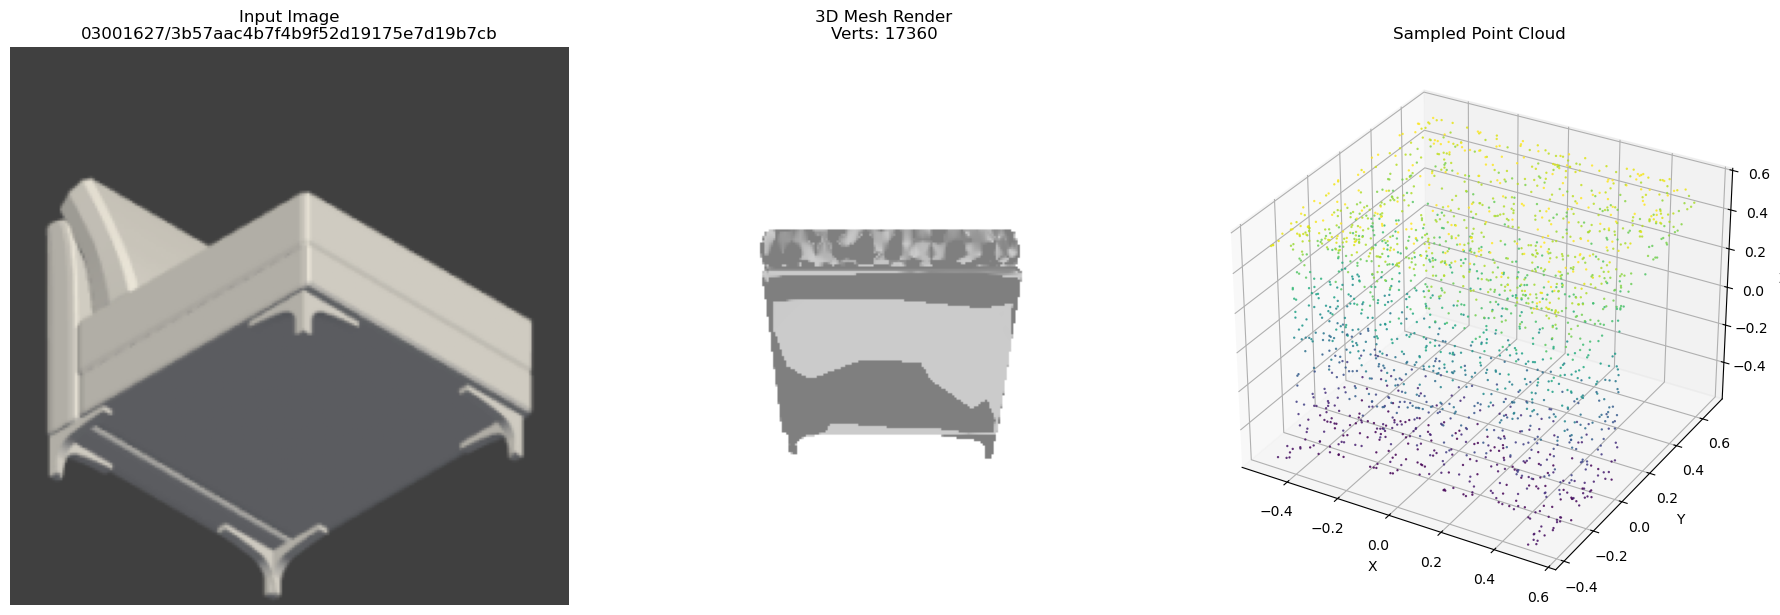


--- Sample Details ---
Class: 03001627
Object: 3b57aac4b7f4b9f52d19175e7d19b7cb
Image shape: torch.Size([3, 224, 224])
Mesh vertices: 17360
Mesh faces: 69344
Number of views: 16

----------------------------------------
BATCH OVERVIEW
----------------------------------------


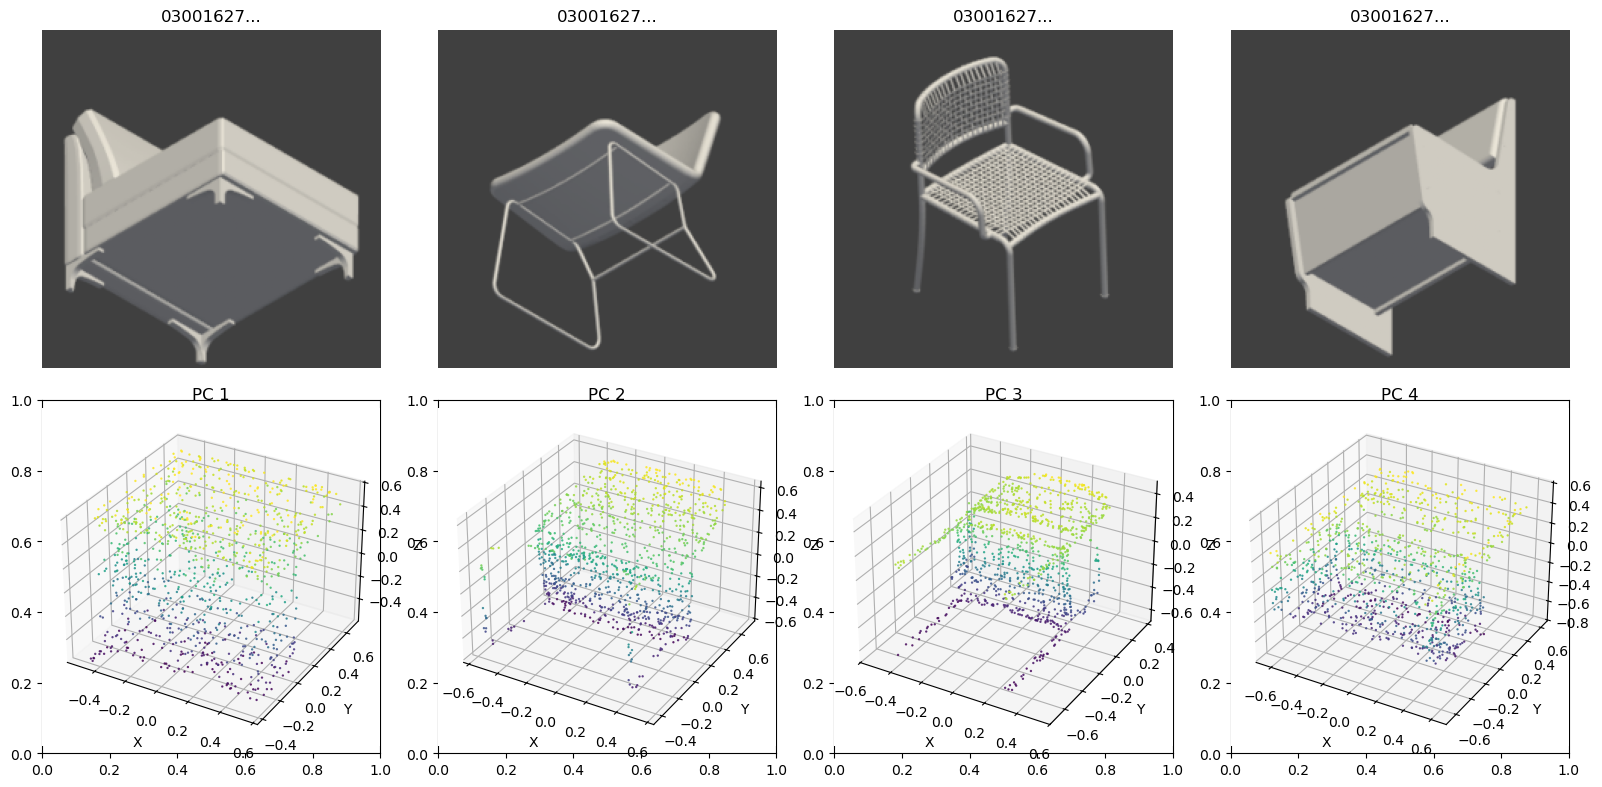


✅ Visualization complete!

----------------------------------------
DATA STATISTICS
----------------------------------------
Sample 1:
  - Class: 03001627
  - Object: 3b57aac4b7f4b9f52d19175e7d19b7cb
  - Vertices: 17,360
  - Faces: 69,344
  - Views: 16

Sample 2:
  - Class: 03001627
  - Object: 1be38f2624022098f71e06115e9c3b3e
  - Vertices: 31,006
  - Faces: 123,670
  - Views: 16

Sample 3:
  - Class: 03001627
  - Object: 4a783b2ae8fba8b29dcf2183c858e6e5
  - Vertices: 17,794
  - Faces: 70,740
  - Views: 16



In [28]:
# --- Complete Data Visualization ---
# Test if we can load a batch
try:
    print("Loading sample batch...")
    sample_images, sample_meshes, sample_metadata = next(iter(dataloader))

    print(f"✅ Batch loaded successfully!")
    print(f"   - Images shape: {sample_images.shape}")
    print(f"   - Number of meshes: {len(sample_meshes)}")
    print(f"   - Batch size: {len(sample_metadata)}")

    print("\n" + "-" * 40)
    print("DETAILED SAMPLE VISUALIZATION")
    print("-" * 40)

    # Visualize first sample in detail
    visualize_complete_sample(
        images=sample_images,
        meshes=sample_meshes,
        metadata=sample_metadata,
        sample_idx=0,
        device=device
    )

    # If batch has multiple samples, show overview
    if len(sample_metadata) > 1:
        print("\n" + "-" * 40)
        print("BATCH OVERVIEW")
        print("-" * 40)

        quick_batch_overview(
            images=sample_images,
            meshes=sample_meshes,
            metadata=sample_metadata,
            max_samples=min(4, len(sample_metadata))
        )

    print("\n✅ Visualization complete!")

    # Additional statistics
    print("\n" + "-" * 40)
    print("DATA STATISTICS")
    print("-" * 40)

    for i, meta in enumerate(sample_metadata[:3]):  # Show first 3
        mesh = sample_meshes[i] if len(sample_meshes) > 1 else sample_meshes
        print(f"Sample {i+1}:")
        print(f"  - Class: {meta['class_id']}")
        print(f"  - Object: {meta['obj_id']}")
        print(f"  - Vertices: {mesh.verts_list()[0].shape[0]:,}")
        print(f"  - Faces: {mesh.faces_list()[0].shape[0]:,}")
        print(f"  - Views: {meta['num_views']}")
        print()

except Exception as e:
    print(f"❌ Error in visualization: {e}")
    import traceback
    traceback.print_exc()

In [30]:
# Test individual components
print("\n" + "-" * 40)
print("COMPONENT TESTING")
print("-" * 40)

try:
    # Test mesh to point cloud conversion
    from hiegan.utils.mesh_utils import mesh_to_pointcloud

    print("Testing mesh to point cloud conversion...")
    test_mesh = sample_meshes[0] if len(sample_meshes) > 1 else sample_meshes
    test_points = mesh_to_pointcloud(test_mesh, num_samples=1024)
    print(f"✅ Point cloud shape: {test_points.shape}")

    # Test renderer
    print("Testing mesh renderer...")
    from hiegan.utils.render_utils import simple_renderer, render_mesh_rgb

    renderer = simple_renderer(device=device)
    rendered = render_mesh_rgb(test_mesh, renderer, device=device)
    print(f"✅ Rendered image shape: {rendered.shape}")

except Exception as e:
    print(f"❌ Component test failed: {e}")

print("\n" + "=" * 60)
print("VISUALIZATION READY - Data pipeline is working!")
print("Next step: Implement Vision Transformer Encoder")
print("=" * 60)


----------------------------------------
COMPONENT TESTING
----------------------------------------
Testing mesh to point cloud conversion...
✅ Point cloud shape: torch.Size([1, 1024, 3])
Testing mesh renderer...
✅ Rendered image shape: torch.Size([1, 256, 256, 3])

VISUALIZATION READY - Data pipeline is working!
Next step: Implement Vision Transformer Encoder


In [31]:
# === MODEL INITIALIZATION ===
print("🔧 Initializing models...")

from hiegan.models.generator import HIEGenerator
from hiegan.models.discriminator import PointCloudDiscriminator
from hiegan.utils.loss_utils import HIEGANLoss
from hiegan.utils.mesh_utils import mesh_to_pointcloud

# Initialize models
generator = HIEGenerator(latent_dim=cfg.LATENT_DIM).to(device)
discriminator = PointCloudDiscriminator().to(device)

# Create template mesh (icosphere)
template_mesh = ico_sphere(level=2, device=device)
template_verts = template_mesh.verts_list()[0]  # Shape: (V, 3)
template_faces = template_mesh.faces_list()[0]  # Shape: (F, 3)
template_edges = template_mesh.edges_packed().t().contiguous()  # Shape: (2, E)

print(f"✅ Models initialized:")
print(f"   - Generator: {sum(p.numel() for p in generator.parameters()):,} parameters")
print(f"   - Discriminator: {sum(p.numel() for p in discriminator.parameters()):,} parameters")
print(f"   - Template mesh: {template_verts.shape[0]} vertices, {template_faces.shape[0]} faces")

# === OPTIMIZERS AND LOSS ===
g_optimizer = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

criterion = HIEGANLoss(
    chamfer_weight=1.0,
    sdf_weight=0.5,
    explicit_weight=0.5,
    fusion_weight=1.0
)

print("✅ Optimizers and loss function ready")

🔧 Initializing models...
✅ Models initialized:
   - Generator: 87,379,977 parameters
   - Discriminator: 74,625 parameters
   - Template mesh: 162 vertices, 320 faces
✅ Optimizers and loss function ready


In [32]:
# === TRAINING METRICS TRACKING ===
class TrainingTracker:
    def __init__(self):
        self.g_losses = []
        self.d_losses = []
        self.chamfer_losses = []
        self.epoch_metrics = []

    def update(self, g_loss, d_loss, chamfer_loss):
        self.g_losses.append(g_loss)
        self.d_losses.append(d_loss)
        self.chamfer_losses.append(chamfer_loss)

    def epoch_summary(self, epoch):
        metrics = {
            'epoch': epoch,
            'avg_g_loss': sum(self.g_losses[-len(dataloader):]) / len(dataloader),
            'avg_d_loss': sum(self.d_losses[-len(dataloader):]) / len(dataloader),
            'avg_chamfer': sum(self.chamfer_losses[-len(dataloader):]) / len(dataloader),
        }
        self.epoch_metrics.append(metrics)
        return metrics

tracker = TrainingTracker()

In [33]:
# === TRAINING FUNCTIONS ===
def save_checkpoint(epoch, save_path=None):
    """Save model checkpoint"""
    if save_path is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(cfg.CHECKPOINT_DIR, f'hiegan_epoch_{epoch}_{timestamp}.pth')

    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'config': cfg,
        'template_verts': template_verts,
        'template_faces': template_faces,
        'template_edges': template_edges,
        'training_metrics': tracker.epoch_metrics
    }

    torch.save(checkpoint, save_path)
    return save_path

def train_one_epoch(epoch, max_batches=None):
    """Train for one epoch"""
    generator.train()
    discriminator.train()

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{cfg.EPOCHS}")

    for batch_idx, (imgs, gt_meshes, metadata) in enumerate(pbar):
        if max_batches and batch_idx >= max_batches:
            break

        batch_size = imgs.shape[0]

        # Move data to device
        imgs = imgs.to(device)
        gt_meshes = gt_meshes.to(device)

        # Generate random sample points for implicit branch
        sample_points = torch.randn(batch_size, 1024, 3, device=device) * 0.8

        # === TRAIN DISCRIMINATOR ===
        d_optimizer.zero_grad()

        # Real  sample points from ground truth meshes
        try:
            real_points = mesh_to_pointcloud(gt_meshes, num_samples=2048)
        except:
            print(f"Skipping batch {batch_idx} - mesh sampling failed")
            continue

        # Fake  generate with current generator (no gradients)
        with torch.no_grad():
            fake_outputs = generator(
                imgs=imgs,
                template_mesh_vertices=template_verts,
                template_mesh_edges=template_edges,
                sample_xyz=sample_points,
                enable_fusion=True
            )

        # Get points for discriminator
        if 'fused_points' in fake_outputs:
            fake_points = fake_outputs['fused_points']
        elif 'deformed_vertices' in fake_outputs:
            # Sample points from deformed vertices
            num_verts = fake_outputs['deformed_vertices'].shape[1]
            if num_verts >= 2048:
                indices = torch.randint(0, num_verts, (2048,), device=device)
                fake_points = fake_outputs['deformed_vertices'][:, indices, :]
            else:
                fake_points = fake_outputs['deformed_vertices']
        else:
            print(f"Skipping batch {batch_idx} - no valid generator output")
            continue

        # Discriminator forward pass
        d_real = discriminator(real_points)
        d_fake = discriminator(fake_points.detach())

        # Discriminator loss (WGAN-GP style or standard BCE)
        d_real_loss = nn.BCEWithLogitsLoss()(d_real, torch.ones_like(d_real))
        d_fake_loss = nn.BCEWithLogitsLoss()(d_fake, torch.zeros_like(d_fake))
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # === TRAIN GENERATOR ===
        g_optimizer.zero_grad()

        # Generate outputs with gradients
        gen_outputs = generator(
            imgs=imgs,
            template_mesh_vertices=template_verts,
            template_mesh_edges=template_edges,
            sample_xyz=sample_points,
            enable_fusion=True
        )

        # Get points for adversarial loss
        if 'fused_points' in gen_outputs:
            gen_points = gen_outputs['fused_points']
        elif 'deformed_vertices' in gen_outputs:
            num_verts = gen_outputs['deformed_vertices'].shape[1]
            if num_verts >= 2048:
                indices = torch.randint(0, num_verts, (2048,), device=device)
                gen_points = gen_outputs['deformed_vertices'][:, indices, :]
            else:
                gen_points = gen_outputs['deformed_vertices']
        else:
            continue

        # Adversarial loss
        d_gen = discriminator(gen_points)
        g_adv_loss = nn.BCEWithLogitsLoss()(d_gen, torch.ones_like(d_gen))

        # Reconstruction loss
        try:
            g_recon_loss, loss_dict = criterion(gen_outputs, gt_meshes)
        except:
            # Fallback: simple chamfer loss
            gt_points = mesh_to_pointcloud(gt_meshes, num_samples=gen_points.shape[1])
            g_recon_loss = nn.MSELoss()(gen_points, gt_points)
            loss_dict = {'chamfer': g_recon_loss}

        # Total generator loss
        g_loss = 0.1 * g_adv_loss + g_recon_loss

        g_loss.backward()
        g_optimizer.step()

        # Track metrics
        chamfer_loss = loss_dict.get('fusion_chamfer', loss_dict.get('chamfer', torch.tensor(0.0)))
        tracker.update(g_loss.item(), d_loss.item(), chamfer_loss.item())

        # Update progress bar
        pbar.set_postfix({
            'G_Loss': f'{g_loss.item():.4f}',
            'D_Loss': f'{d_loss.item():.4f}',
            'G_Adv': f'{g_adv_loss.item():.4f}',
            'Chamfer': f'{chamfer_loss.item():.4f}'
        })

    return batch_idx + 1

In [34]:
# === START TRAINING ===
print("\n" + "🚀 STARTING TRAINING" + "\n" + "=" * 40)

try:
    # Test run first (1 epoch, 3 batches)
    print("🔍 Test run (1 epoch, 3 batches)...")
    num_batches = train_one_epoch(0, max_batches=3)

    if num_batches > 0:
        print("✅ Test run successful! Starting full training...")

        # Full training loop
        for epoch in range(min(5, cfg.EPOCHS)):  # Limit to 5 epochs for safety
            print(f"\n📊 Epoch {epoch+1}/{min(5, cfg.EPOCHS)}")

            # Train one epoch
            train_one_epoch(epoch, max_batches=None)  # Full epoch

            # Get epoch summary
            metrics = tracker.epoch_summary(epoch)
            print(f"   📈 Avg G Loss: {metrics['avg_g_loss']:.6f}")
            print(f"   📈 Avg D Loss: {metrics['avg_d_loss']:.6f}")
            print(f"   📈 Avg Chamfer: {metrics['avg_chamfer']:.6f}")

            # Save checkpoint every epoch
            checkpoint_path = save_checkpoint(epoch + 1)
            print(f"   💾 Checkpoint saved: {os.path.basename(checkpoint_path)}")

            # Early stopping check (optional)
            if metrics['avg_chamfer'] < 0.001:
                print("   🎯 Early stopping - excellent reconstruction!")
                break

    print("\n✅ Training completed successfully!")
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

    # Save emergency checkpoint
    try:
        emergency_path = save_checkpoint(-1)
        print(f"🆘 Emergency checkpoint saved: {emergency_path}")
    except:
        print("Failed to save emergency checkpoint")

print("\n" + "=" * 60)
print("TRAINING STATUS SUMMARY")
print("=" * 60)
print(f"📁 Checkpoints saved in: {cfg.CHECKPOINT_DIR}")
print(f"📊 Total training batches: {len(tracker.g_losses)}")
print(f"🎯 Best Chamfer loss: {min(tracker.chamfer_losses) if tracker.chamfer_losses else 'N/A'}")
print("=" * 60)


🚀 STARTING TRAINING
🔍 Test run (1 epoch, 3 batches)...


Epoch 1/100:   3%|▎         | 3/117 [00:12<07:55,  4.17s/it, G_Loss=0.4761, D_Loss=0.6952, G_Adv=0.6494, Chamfer=0.1310]


✅ Test run successful! Starting full training...

📊 Epoch 1/5


Epoch 1/100: 100%|██████████| 117/117 [07:53<00:00,  4.05s/it, G_Loss=0.3156, D_Loss=0.6177, G_Adv=0.8263, Chamfer=0.0455]


   📈 Avg G Loss: 0.328517
   📈 Avg D Loss: 0.668340
   📈 Avg Chamfer: 0.048546
   💾 Checkpoint saved: hiegan_epoch_1_20250825_152706.pth

📊 Epoch 2/5


Epoch 2/100: 100%|██████████| 117/117 [07:31<00:00,  3.86s/it, G_Loss=0.2379, D_Loss=0.2338, G_Adv=1.4476, Chamfer=0.0523]


   📈 Avg G Loss: 0.252875
   📈 Avg D Loss: 0.477052
   📈 Avg Chamfer: 0.054542
   💾 Checkpoint saved: hiegan_epoch_2_20250825_153439.pth

📊 Epoch 3/5


Epoch 3/100: 100%|██████████| 117/117 [07:10<00:00,  3.68s/it, G_Loss=0.3204, D_Loss=0.1309, G_Adv=2.4377, Chamfer=0.0412]


   📈 Avg G Loss: 0.295883
   📈 Avg D Loss: 0.195412
   📈 Avg Chamfer: 0.054016
   💾 Checkpoint saved: hiegan_epoch_3_20250825_154150.pth

📊 Epoch 4/5


Epoch 4/100: 100%|██████████| 117/117 [07:15<00:00,  3.72s/it, G_Loss=0.2886, D_Loss=0.1647, G_Adv=2.1775, Chamfer=0.0477]


   📈 Avg G Loss: 0.305268
   📈 Avg D Loss: 0.176841
   📈 Avg Chamfer: 0.055431
   💾 Checkpoint saved: hiegan_epoch_4_20250825_154906.pth

📊 Epoch 5/5


Epoch 5/100: 100%|██████████| 117/117 [07:08<00:00,  3.67s/it, G_Loss=0.3225, D_Loss=0.1016, G_Adv=2.4710, Chamfer=0.0506]


   📈 Avg G Loss: 0.362014
   📈 Avg D Loss: 0.150315
   📈 Avg Chamfer: 0.076237
   💾 Checkpoint saved: hiegan_epoch_5_20250825_155616.pth

✅ Training completed successfully!

TRAINING STATUS SUMMARY
📁 Checkpoints saved in: /Users/sundar/PycharmProjects/HIE-GAN/outputs/checkpoints
📊 Total training batches: 588
🎯 Best Chamfer loss: 0.03371533378958702


✅ Model loaded successfully!
✅ Image loaded: torch.Size([1, 3, 224, 224])
✅ 3D generation complete!


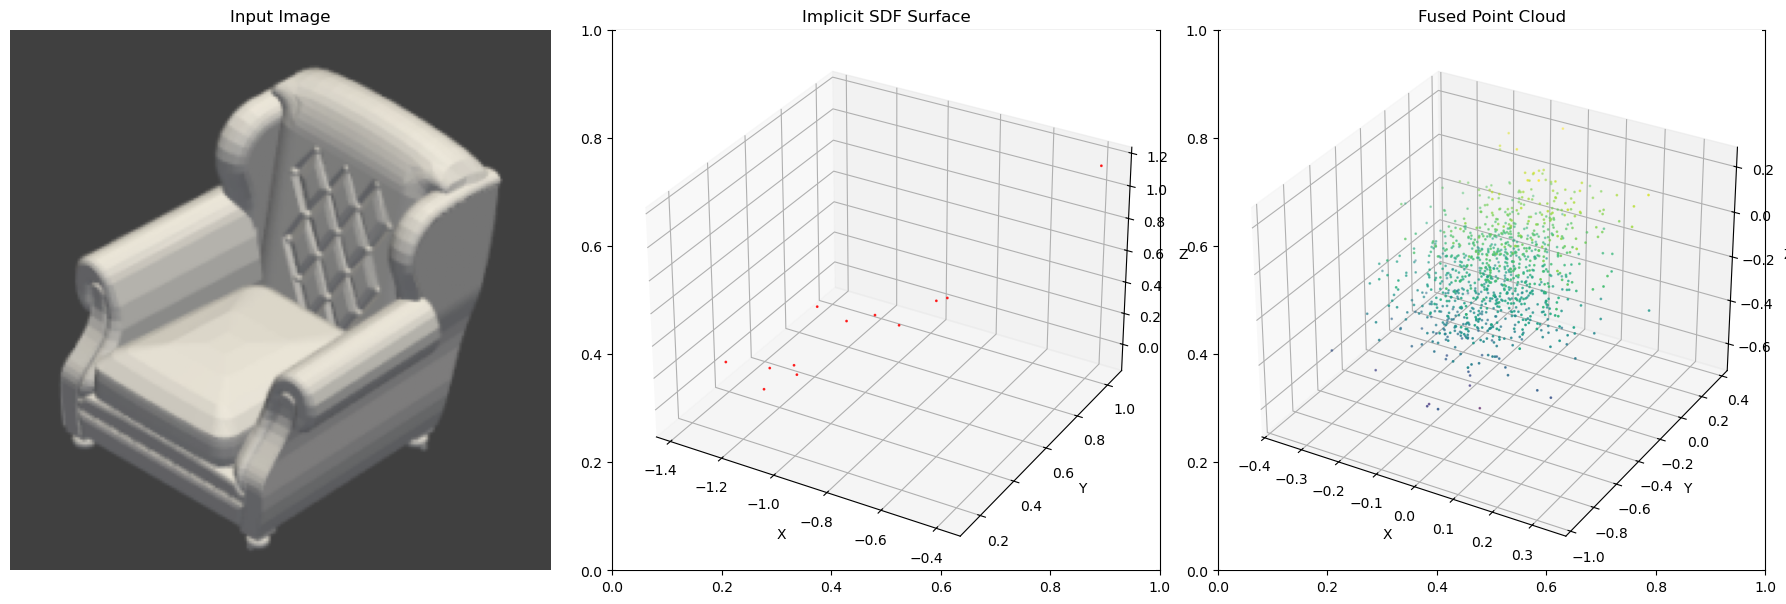


SINGLE IMAGE TEST RESULTS
Input image shape: torch.Size([1, 3, 224, 224])
latent: torch.Size([1, 512])
implicit_sdf: torch.Size([1, 1024, 1])
explicit_displacements: torch.Size([1, 162, 3])
deformed_vertices: torch.Size([1, 162, 3])
fused_points: torch.Size([1, 1024, 3])
fused_vertices: torch.Size([1, 1024, 3])
implicit_weight: torch.Size([1, 1, 1])
explicit_weight: torch.Size([1, 1, 1])

✅ Single image test completed!


In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch3d.utils import ico_sphere
from hiegan.models.generator import HIEGenerator
from hiegan.utils.mesh_utils import mesh_to_pointcloud
import torchvision.transforms as T

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HIEGenerator(latent_dim=512).to(device)
model.eval()

# Load checkpoint (use weights_only=False for simplicity)
checkpoint_path = cfg.CHECKPOINT_DIR + "/hiegan_epoch_5_20250825_155616.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['generator_state_dict'])
print("✅ Model loaded successfully!")

# --- Prepare Template Mesh ---
template_mesh = ico_sphere(level=2, device=device)
template_verts = template_mesh.verts_list()[0]
template_edges = template_mesh.edges_packed().t().contiguous()

# --- Load and Preprocess Single Image ---
# Option 1: Use an image from your dataset
image_path = "/Users/sundar/PycharmProjects/HIE-GAN/dataset/ShapeNetCore.v2/03001627/5f256dd64efba74a4316d3320fdfa899/images/11_iso_-xy-z.png"

# Option 2: Or use any test image
# image_path = "/path/to/your/test/image.jpg"

# Preprocessing transform (same as training)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and process image
pil_image = Image.open(image_path).convert("RGB")
input_tensor = transform(pil_image).unsqueeze(0).to(device)  # Add batch dimension

print(f"✅ Image loaded: {input_tensor.shape}")

# --- Generate 3D Output ---
with torch.no_grad():
    # Sample points for implicit branch
    sample_points = torch.randn(1, 1024, 3, device=device) * 0.5

    # Forward pass
    outputs = model(
        imgs=input_tensor,
        template_mesh_vertices=template_verts,
        template_mesh_edges=template_edges,
        sample_xyz=sample_points,
        enable_fusion=True
    )

print("✅ 3D generation complete!")

# --- Visualize Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Input Image
img_display = (input_tensor[0].permute(1, 2, 0).cpu().numpy() + 1) / 2
axes[0].imshow(np.clip(img_display, 0, 1))
axes[0].set_title('Input Image')
axes[0].axis('off')

# 2. Implicit SDF Visualization
if 'implicit_sdf' in outputs:
    sdf_vals = outputs['implicit_sdf'][0].cpu().numpy().squeeze()
    points = sample_points[0].cpu().numpy()

    axes[1] = plt.subplot(1, 3, 2, projection='3d')
    surface_points = points[np.abs(sdf_vals) < 0.05]  # Near-surface points

    if len(surface_points) > 0:
        axes[1].scatter(surface_points[:, 0], surface_points[:, 1], surface_points[:, 2],
                       c='red', s=1, alpha=0.8)
    axes[1].set_title('Implicit SDF Surface')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].set_zlabel('Z')

# 3. Final Output (Fused or Explicit)
axes[2] = plt.subplot(1, 3, 3, projection='3d')

if 'fused_mesh' in outputs:
    # Render actual mesh
    fused_mesh = outputs['fused_mesh']
    vertices = fused_mesh.verts_list()[0].cpu().numpy()
    faces = fused_mesh.faces_list()[0].cpu().numpy()
    
    # Plot mesh faces (not just vertices)
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    # Create face polygons
    face_vertices = vertices[faces]
    poly3d = [[face_vertices[j] for j in range(3)] for face_vertices in face_vertices]
    
    axes[2].add_collection3d(Poly3DCollection(poly3d, alpha=0.7, facecolor='lightblue', edgecolor='black'))
    axes[2].set_title('Fused 3D Mesh')
    
elif 'fused_points' in outputs:
    # Fallback to point cloud
    final_points = outputs['fused_points'][0].cpu().numpy()
    axes[2].scatter(final_points[:, 0], final_points[:, 1], final_points[:, 2], 
                   c=final_points[:, 2], cmap='viridis', s=1)
    axes[2].set_title('Fused Point Cloud')

axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].set_zlabel('Z')

plt.tight_layout()
plt.show()

# --- Print Summary ---
print("\n" + "="*50)
print("SINGLE IMAGE TEST RESULTS")
print("="*50)
print(f"Input image shape: {input_tensor.shape}")
for key, value in outputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}")
    else:
        print(f"{key}: {type(value)}")

print("\n✅ Single image test completed!")
